In [1]:
import torch
import numpy as np

from sEMGdata import sEMGData
from utils import normalize, onehot
from torch.utils.data import Dataset

In [ ]:
class sEMGDataset(Dataset):
  def __init__(self, signal, label, transform=None, verbose=False):
    self.signal = torch.from_numpy(signal)
    self.label  = torch.from_numpy(label)
  
  def __len__(self):
    return np.shape(self.label)[0]
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    signal = self.signal[idx,...]
    label  = self.label[idx,...]
    
    return signal, label
        

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        signal, label = sample['signal'], sample['label']
        
        return {'signal': torch.from_numpy(signal),
                'label' : torch.from_numpy(label)}    
    

In [23]:
# load the data and labels
sEMG_vowels = sEMGData(file_dir="data/subjects_40_vowels_v6.mat")

# leave-one-subject-out data partition
x_train, y_train, x_test, y_test = sEMG_vowels.load_data(sub_test=0, sub_normalize=True)
# Normalize the signal per channel
x_train, x_test = normalize(x_train, x_test)
# Onehot encode the label
y_train, y_test = onehot(y_train), onehot(y_test)


Total number of subjects:       40
Testing Subject ID:             44
Testing Subject VFI-1:          0
# of Testing Samples:           165
# of Healthy Training Samples:  3037
# of Fatigued Training Samples: 3270


(-5.0, 5.0)

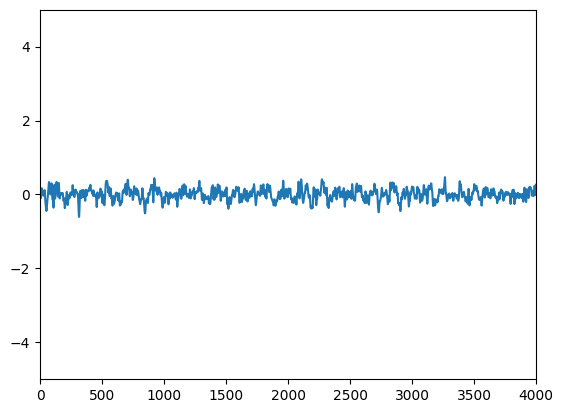

In [28]:
import matplotlib.pyplot as plt
i = np.random.randint(x_train.shape[0])
plt.plot(x_train[i,:,0])
plt.xlim([0, 4000])
plt.ylim([-5,5])